In [ ]:
#Pipeline for creating plots and mapped properties of binned.fits files created in the pre_to_fit pipeline 
#Very fast to run everything in this notebook and a lot of customizability in regard to how to disply plots
#For simplicity this pipeline uses the plots generated in pixedfit tutorial notebooks

#Future versions can generate the corner plots, SED fit plots, and SFH plots of all bins created in previous pipeline.

In [2]:
from piXedfit.piXedfit_analysis import plot_SED
from piXedfit.piXedfit_analysis import plot_corner
from piXedfit.piXedfit_analysis import plot_sfh_mcmc
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

%matplotlib inline

In [5]:
#Produces fitted SED plot, corner plot, and sfh plot of an individual bin.
for i in range (16,17):
    
    name_sampler_fits = f'mcmc_bin{i}.fits'
    
    start = name_sampler_fits.find('bin') + 3
    end = name_sampler_fits.find('.fits')
    bin_number = int(name_sampler_fits[start:end])
    
    with fits.open("pixbin_fluxmap.fits") as hdul:
        bin_map = hdul["BIN_MAP"].data
        flux_map = hdul["BIN_FLUX"].data[0]  # First band of flux
    
    # Flip to match display orientation
    flux_map = np.flipud(flux_map)
    bin_map = np.flipud(bin_map)
    
    # Apply log scaling to flux for better contrast
    flux_map_scaled = np.log10(flux_map + 1e-3)  # Avoid log(0)
    vmin, vmax = np.percentile(flux_map_scaled, [1, 99])  # Trim outliers
    
    # Choose bin to highlight
    target_bin_id = bin_number
    highlight_mask = (bin_map == target_bin_id)
    
    # Plot
    plt.figure(figsize=(8, 6))
    
    # Background galaxy
    plt.imshow(flux_map_scaled, cmap='gray', vmin=vmin, vmax=vmax, origin='upper')
    
    # Overlay highlighted bin
    plt.imshow(np.ma.masked_where(~highlight_mask, highlight_mask), 
               cmap=mcolors.ListedColormap(['red']), alpha=1, origin='upper')
    
    plt.axis('off')
    plt.tight_layout()
    hdul.close()
    plt.savefig(f'visual_mcmc_bin{bin_number}', bbox_inches='tight', dpi=100)
    
    wunit = 0 #The units of the x-axis (wavelength) of the graph. Options are: 0 or 'angstrom' for Angstrom unit and 1 or 'micron' for micron unit.
    xrange = None #Range in units of 'wunit' to be used for x-axis of SED fitted plot. Format: [xmin, xmax], only use ints. If none a default range will be used.
    
    funit = 0 #The units of the y-axis (flux) of the graph. Options are: 0 or 'erg/s/cm2/A', 1 or 'erg/s/cm2', and 2 or 'Jy'.
    yrange = None #Range in units of 'funit' to be used for y-axis of SED fitted plot. Format: [ymin, ymax], only use ints. If none a default range will be used.
    
    #Function to plot the SED fit generated from the fitting step.
    #Default options can be changed for customizability, but options above will most change how the data itself is shown.
    plot_SED(name_sampler_fits,logscale_x=False,logscale_y=True,xrange=xrange,yrange=yrange,wunit=wunit,funit=funit, 
             decompose=0,xticks=None,photo_color='red',residual_range=[-0.5,0.5],show_original_spec=True,fontsize_tick=18,fontsize_label=25,
    	     show_legend=True, loc_legend=4, fontsize_legend=18, markersize=100, lw=2.0, name_plot=None)
    
    #Function to generate the corner plot
    #Parameters and paramater ranges can be changed, but heavily advised to just use default options and only insert fits name.
    plot_corner(name_sampler_fits)
    
    nchains = 200 # Number of randomly chosen sampler chains (from the full samplers stored in the FITS file) to be used for calculating the inferred SFH. Default of 200.
    
    #Function to generate the SFH plot
    #Other parts of the graph may be changed, but heavily advised to just use default options and only insert fits name.
    sfh = plot_sfh_mcmc(name_sampler_fits,nchains=nchains,lbacktime_max=2.0)

Plotting posteriors probability distributions
=> Number of parameters: 9


In [9]:
#Produces a fits file of the mapped properties of the galaxy that can be displayed visually in the following cells. Additionally prints the data within the fits.
from piXedfit.piXedfit_fitting import maps_parameters

fits_binmap = "pixbin_fluxmap.fits"
hdu = fits.open(fits_binmap)
#nbins = int(hdu[0].header['NBINS']) #Alternatively can just set 'nbins' to equal the number of bins you wish to use.
nbins = 17
hdu.close()

bin_ids = []
name_sampler_fits = []
for ii in range(0,nbins):
    bin_ids.append(ii)
    name = "mcmc_bin%d.fits" % (ii+1) #Name of the mcmc_bin.fits files generated in the pre_to_fit pipeline. Default is the default naming convention generated by fitting function.
    name_sampler_fits.append(name)

fits_fluxmap = "fluxmap.fits"
name_out_fits = "maps_properties.fits"
refband_SFR = None #Index of the filter used for reference in dividing map of SFR in bin space into map of SFR in pixel space. Deafult will choose shortest wavelength filter.
refband_SM = None #Index of filter used for reference in dividing map of stellar mass in bin space into map of stellar mass in pixel space. Default will choose shortest wavelength filter.

#Converts data from the binmap and fluxmap into a fits files with mapped properties of the galaxy.
maps_parameters(fits_binmap, bin_ids, name_sampler_fits, fits_fluxmap=fits_fluxmap, refband_SFR=refband_SFR, refband_SM=refband_SM, name_out_fits=None)


maps = fits.open("fitres_pixbin_fluxmap.fits")
maps.info()

#Get the galaxy's region
gal_region = maps['galaxy_region'].data

#Calculate physical size of a single pixel
from piXedfit.piXedfit_images import kpc_per_pixel

z = float(maps[0].header['gal_z']) 
arcsec_per_pixel = 0.6704357586585542 #*Edit this later to naturally grab PIXAR_AR from the header of the original file*. This float can be manually set if you know the pixel area.            
kpc_per_pix = kpc_per_pixel(z,arcsec_per_pixel)
print ("kpc/pixel = %lf" % kpc_per_pix)

Filename: fitres_pixbin_fluxmap.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      40   ()      
  1  GALAXY_REGION    1 ImageHDU         8   (1024, 1024)   float64   
  2  BIN-LOGZSOL-P16    1 ImageHDU         8   (1024, 1024)   float64   
  3  BIN-LOGZSOL-P50    1 ImageHDU         8   (1024, 1024)   float64   
  4  BIN-LOGZSOL-P84    1 ImageHDU         8   (1024, 1024)   float64   
  5  BIN-LOG_TAU-P16    1 ImageHDU         8   (1024, 1024)   float64   
  6  BIN-LOG_TAU-P50    1 ImageHDU         8   (1024, 1024)   float64   
  7  BIN-LOG_TAU-P84    1 ImageHDU         8   (1024, 1024)   float64   
  8  BIN-LOG_ALPHA-P16    1 ImageHDU         8   (1024, 1024)   float64   
  9  BIN-LOG_ALPHA-P50    1 ImageHDU         8   (1024, 1024)   float64   
 10  BIN-LOG_ALPHA-P84    1 ImageHDU         8   (1024, 1024)   float64   
 11  BIN-LOG_BETA-P16    1 ImageHDU         8   (1024, 1024)   float64   
 12  BIN-LOG_BETA-P50    1 ImageHDU       

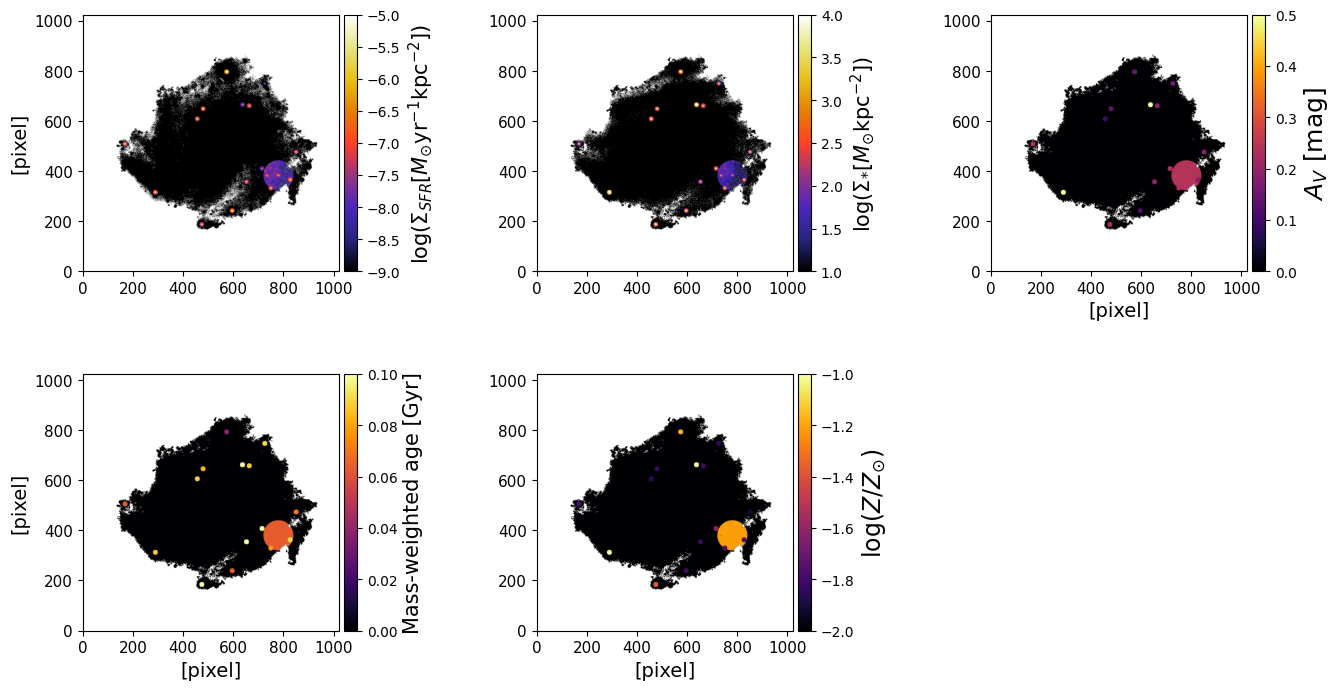

In [14]:
#Generates the mapped properties that can visually be seen.

rows, cols = np.where(gal_region != 1) #Get pixels outside the galaxy's region of interest

#Stellar mass surface density. Currently unknown why the arcsecond area of pixels can be used.
map_prop_SM = np.log10(np.power(10.0,maps['pix-log_mass-p50'].data)/kpc_per_pix/kpc_per_pix)
map_prop_SM[rows,cols] = float('nan')  

#Surface density of SFR. Currently unknown why the arcsecond area of pixels can be used.
map_SFR = np.log10(np.power(10.0,maps['pix-log_sfr-p50'].data)/kpc_per_pix/kpc_per_pix)
map_SFR[rows,cols] = float('nan') 

#Av dust attenuation. Currently the value of 1.086 being chosen is unknown 
map_Av = 1.086*maps['bin-dust2-p50'].data
map_Av[rows,cols] = float('nan')

#Stellar metallicity
map_logzsol  = maps['bin-logzsol-p50'].data
map_logzsol[rows,cols] = float('nan') 

#Mass-weighted age
map_mw_age  = np.power(10.0,maps['bin-log_mw_age-p50'].data)
map_mw_age[rows,cols] = float('nan') 

#All of the following can be customized for different values that correctly plot the properties of the data input.
#Default values are just those adopted from personal use.

%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig1 = plt.figure(figsize=(14,7))

###=> SFR surface density
f1 = fig1.add_subplot(2, 3, 1)
plt.ylabel('[pixel]', fontsize=14)
plt.setp(f1.get_xticklabels(), fontsize=11)
plt.setp(f1.get_yticklabels(), fontsize=11)

plt.imshow(map_SFR, origin='lower', cmap='CMRmap', vmin=-9.0, vmax=-5.0)
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = plt.colorbar(cax=cax)
cb.set_label(r'log($\Sigma_{SFR}[M_{\odot}\rm{yr}^{-1}\rm{kpc}^{-2}]$)', fontsize=15)

###=> stellar mass surface density
f1 = fig1.add_subplot(2, 3, 2)
plt.setp(f1.get_xticklabels(), fontsize=11)
plt.setp(f1.get_yticklabels(), fontsize=11)

plt.imshow(map_prop_SM, origin='lower', cmap='CMRmap', vmin=1, vmax=4)
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = plt.colorbar(cax=cax)
cb.set_label(r'log($\Sigma_{*}[M_{\odot}\rm{kpc}^{-2}]$)', fontsize=15)

###=> AV dust attenuation
f1 = fig1.add_subplot(2, 3, 3)
plt.xlabel('[pixel]', fontsize=14)
plt.setp(f1.get_xticklabels(), fontsize=11)
plt.setp(f1.get_yticklabels(), fontsize=11)

plt.imshow(map_Av, origin='lower', cmap='inferno', vmin=0, vmax=0.5)
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = plt.colorbar(cax=cax)
cb.set_label(r'$A_{V}$ [mag]', fontsize=18)

### mass-weighted age
f1 = fig1.add_subplot(2, 3, 4)
plt.xlabel('[pixel]', fontsize=14)
plt.ylabel('[pixel]', fontsize=14)
plt.setp(f1.get_xticklabels(), fontsize=11)
plt.setp(f1.get_yticklabels(), fontsize=11)

plt.imshow(map_mw_age, origin='lower', cmap='inferno', vmin=0, vmax=0.1)
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = plt.colorbar(cax=cax)
cb.set_label('Mass-weighted age [Gyr]', fontsize=15)

### stellar metallicity
f1 = fig1.add_subplot(2, 3, 5)
plt.xlabel('[pixel]', fontsize=14)
plt.setp(f1.get_xticklabels(), fontsize=11)
plt.setp(f1.get_yticklabels(), fontsize=11)

plt.imshow(map_logzsol, origin='lower', cmap='inferno', vmin=-2.0, vmax=-1.0)
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = plt.colorbar(cax=cax)
cb.set_label(r'log($Z/Z_{\odot}$)', fontsize=17)


plt.subplots_adjust(left=0.07, right=0.95, bottom=0.1, top=0.98, hspace=0.4, wspace=0.4)
plt.savefig('maps_properties.png')
plt.show()

In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Variables for changing the numerical part of the filenames
num_top_row = 1
num_bottom_row = 2

# Image filenames based on the numbers above
images = [
    f'visual_mcmc_bin{num_top_row}.png', f'sed_mcmc_bin{num_top_row}.png', f'sfh_mcmc_bin{num_top_row}.png',
    f'visual_mcmc_bin{num_bottom_row}.png', f'sed_mcmc_bin{num_bottom_row}.png', f'sfh_mcmc_bin{num_bottom_row}.png'
]

# Labels for each row
label_top = f'Bin {num_top_row}'
label_bottom = f'Bin {num_bottom_row}'

# Layout configuration
nrows, ncols = 2, 3  # 2 rows, 3 columns
image_scale = 0.8  # Change this to scale all images
figsize = (4 * image_scale * ncols, 3 * image_scale * nrows)  # Adjust figure size

fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
plt.subplots_adjust(wspace=0.1, hspace=0.3, left=0.01, right=1)  # Adjust spacing dynamically

# Add row labels
fig.text(0.5, 0.95, label_top, ha='center', fontsize=16, fontweight='bold')
fig.text(0.5, 0.48, label_bottom, ha='center', fontsize=16, fontweight='bold')

# Load and display images
for ax, img_path in zip(axes.flat, images):
    img = mpimg.imread(img_path)
    ax.imshow(img, aspect='auto')  # Preserve proportions but allow scaling
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)
plt.savefig(f'comparison_top{num_top_row}_bot{num_bottom_row}')

In [56]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Variables for changing the numerical part of the filenames
num_top_row = 4
num_bottom_row = 25

# Image filenames based on the numbers above
images = [
    f'sed_mcmc_bin{num_top_row}.png', f'sfh_mcmc_bin{num_top_row}.png',
    f'sed_mcmc_bin{num_bottom_row}.png', f'sfh_mcmc_bin{num_bottom_row}.png'
]

# Labels for each row
label_top = f'Bin {num_top_row}'
label_bottom = f'Bin {num_bottom_row}'

# Layout configuration
nrows, ncols = 2, 2  # 2 rows, 3 columns
image_scale = 1  # Change this to scale all images
figsize = (1.2 * image_scale * ncols, 1 * image_scale * nrows)  # Adjust figure size

fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
plt.subplots_adjust(wspace=0.1, hspace=0.1, left=0.01, right=1)  # Adjust spacing dynamically

# Add row labels
fig.text(0.5, 0.91, label_top, ha='center', fontsize=4, fontweight='bold')
fig.text(0.5, 0.48, label_bottom, ha='center', fontsize=4, fontweight='bold')

# Load and display images
for ax, img_path in zip(axes.flat, images):
    img = mpimg.imread(img_path)
    ax.imshow(img, aspect='auto')  # Preserve proportions but allow scaling
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)
plt.savefig(f'new_comparison_top{num_top_row}_bot{num_bottom_row}', dpi=300)

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

# Variables for changing the numerical part of the filenames
for i in range (10,17):
    num_top_row = i
    img_dir = "/mnt/d/pixedfit_testing/ARCSAT/first_attempt/"
    # Image filenames based on the numbers above
    images = [
        f'{img_dir}visual_mcmc_bin{num_top_row}.png', f'{img_dir}sed_mcmc_bin{num_top_row}.png', f'{img_dir}sfh_mcmc_bin{num_top_row}.png',
    ]
    
    # Labels for each row
    label_top = f'Bin {num_top_row}'
    
    # Layout configuration
    nrows, ncols = 1, 3  # 2 rows, 3 columns
    
    # Load all images first to get their dimensions
    all_imgs = [mpimg.imread(img_path) for img_path in images]
    img_heights = [img.shape[0] for img in all_imgs]
    img_widths = [img.shape[1] for img in all_imgs]
    
    # Column scaling factors (adjust these to change relative width of each column)
    col_scale = [1.0, 1.0, 1.0]  # Example: middle column is 20% wider, right column is 20% narrower
    
    # Calculate width ratios based on the original aspect ratios and desired scaling
    # For each column, find the maximum width-to-height ratio
    max_ratios = []
    for col in range(ncols):
        ratios = []
        for row in range(nrows):
            idx = row * ncols + col
            ratio = img_widths[idx] / img_heights[idx]
            ratios.append(ratio)
        max_ratios.append(max(ratios) * col_scale[col])
    
    # Create the figure with GridSpec for proper sizing
    fig = plt.figure(figsize=(12, 8))  # Base figure size, will be adjusted
    gs = fig.add_gridspec(nrows, ncols, width_ratios=max_ratios, hspace=0.2, wspace=0.1)
    
    # Create axes with proper size and add images
    axes = []
    for row in range(nrows):
        for col in range(ncols):
            idx = row * ncols + col
            ax = fig.add_subplot(gs[row, col])
            ax.imshow(all_imgs[idx], aspect='equal')  # Use 'equal' to preserve aspect ratio
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_frame_on(False)
            axes.append(ax)
    
    # Add row labels
    fig.text(0.5, 0.65, label_top, ha='center', fontsize=16, fontweight='bold')
    
    # Save the figure
    plt.savefig(f'bin{num_top_row}_results.png', bbox_inches='tight', dpi = 200)
    plt.close()

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from matplotlib.colors import ListedColormap

# 1) Ensure output folder exists
output_folder = "bin_images"
os.makedirs(output_folder, exist_ok=True)

# 2) Load once
with fits.open("pixbin_fluxmap.fits") as hdul:
    bin_map = hdul["BIN_MAP"].data
    flux_map = hdul["BIN_FLUX"].data[0]  # First band of flux

# 3) Flip to match your original orientation
flux_map = np.flipud(flux_map)
bin_map = np.flipud(bin_map)

# 4) Log-scale with the same parameters as original code
flux_map_scaled = np.log10(flux_map + 1e-3)  # Avoid log(0)
vmin, vmax = np.percentile(flux_map_scaled, [1, 99])  # Trim outliers

# 5) Find all real bins
bin_numbers = np.unique(bin_map)
bin_numbers = bin_numbers[bin_numbers >= 0]  # Filter out negative values if any
print(f"Found {len(bin_numbers)} bins.")

# 6) Loop & plot with black and white background, red highlight
for bin_number in bin_numbers:
    highlight_mask = (bin_map == bin_number)
    if not highlight_mask.any():
        continue
        
    fig, ax = plt.subplots(figsize=(5, 5))
    
    # Use grayscale colormap for the flux map
    img = ax.imshow(flux_map_scaled, cmap='gray', vmin=vmin, vmax=vmax)
    
    # Create a red mask for the selected bin
    masked_data = np.zeros_like(flux_map_scaled)
    masked_data[highlight_mask] = 1
    
    # Overlay the selected bin in bright red
    ax.imshow(masked_data, cmap=ListedColormap(['none', 'red']), alpha=0.5)
    
    # Add contour around the bin for better visibility
    ax.contour(highlight_mask, colors='red', linewidths=1.5)
    
    ax.set_title(f"Bin {bin_number}")
    ax.axis('off')
    
    # 7) Save each one
    save_path = os.path.join(output_folder, f"bin_{bin_number}.png")
    plt.savefig(save_path, bbox_inches='tight', dpi=150)
    plt.close(fig)
    print(f"Saved {save_path}")

print("Processing complete.")

import pandas as pd

# Create separate dicts for flux and error
flux_data = {}
err_data = {}

for i, filt in enumerate(filters):
    flux_data[f"{filt}_flux"] = bin_photo_flux[:, i]
    err_data[f"{filt}_flux_err"] = bin_photo_flux_err[:, i]

# Merge them so that flux columns come first, then err columns
combined_data = {**flux_data, **err_data}

# Create DataFrame
df = pd.DataFrame(combined_data)
df.index.name = 'bin_number'

# Save to CSV
df.to_csv('NGC_6946_photometric.csv')

Found 77 bins.
Saved bin_images/bin_0.0.png
Saved bin_images/bin_1.0.png
Saved bin_images/bin_2.0.png
Saved bin_images/bin_3.0.png
Saved bin_images/bin_4.0.png
Saved bin_images/bin_5.0.png
Saved bin_images/bin_6.0.png
Saved bin_images/bin_7.0.png
Saved bin_images/bin_8.0.png
Saved bin_images/bin_9.0.png
Saved bin_images/bin_10.0.png
Saved bin_images/bin_11.0.png
Saved bin_images/bin_12.0.png
Saved bin_images/bin_13.0.png
Saved bin_images/bin_14.0.png
Saved bin_images/bin_15.0.png
Saved bin_images/bin_16.0.png
Saved bin_images/bin_17.0.png
Saved bin_images/bin_18.0.png
Saved bin_images/bin_19.0.png
Saved bin_images/bin_20.0.png
Saved bin_images/bin_21.0.png
Saved bin_images/bin_22.0.png
Saved bin_images/bin_23.0.png
Saved bin_images/bin_24.0.png
Saved bin_images/bin_25.0.png
Saved bin_images/bin_26.0.png
Saved bin_images/bin_27.0.png
Saved bin_images/bin_28.0.png
Saved bin_images/bin_29.0.png
Saved bin_images/bin_30.0.png
Saved bin_images/bin_31.0.png
Saved bin_images/bin_32.0.png
Saved

ModuleNotFoundError: No module named 'pandas'